# Monowai CC

General tools

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from obspy import read_inventory

import ccf

In [2]:
%matplotlib notebook

In [16]:
ccf.clients.set(sds_root='/Users/psmets/Documents/Research/_data/WaveformArchive/')

In [4]:
# parameters
preprocess = {
    'BHZ': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        ('remove_response', {'output': 'VEL'}),
        ('filter', { 'type': 'highpass', 'freq': 4. }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('interpolate', {'sampling_rate': 50, 'method':'lanczos', 'a':20}),
        ('taper', { 'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
    ],
    'EDH': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('detrend', { 'type': 'demean' }),
        ('remove_sensitivity', {}),
        ('filter', { 'type': 'bandpass', 'freqmin': 4., 'freqmax': 10. }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('decimate', { 'factor': 5 }),
        ('taper', {'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
    ],
}
sampling_rate = 50.
window_length = 86400. # 24h
window_overlap = 0.875 # 21h
clip_max_abs_lag = 3600.*4
title_prefix = 'Monowai Volcanic Centre'
ncfile_prefix = 'MVC.CC.RAW.'

In [5]:
pairs = [
    'IM.H10N1..EDH-IU.RAR.00.BHZ',
    'IM.H10N2..EDH-IU.RAR.00.BHZ',
    'IM.H10N3..EDH-IU.RAR.00.BHZ',
    'IM.H03S1..EDH-IU.RAR.00.BHZ',
    'IM.H03S2..EDH-IU.RAR.00.BHZ',
    'IM.H03S3..EDH-IU.RAR.00.BHZ',
    'IU.RAO.00.BHZ-IU.RAR.00.BHZ',
]
inventory = read_inventory('Monowai_EDH_BHZ.xml')
times = pd.date_range('2015-01-01', '2016-01-01', freq='1D')

### single period

In [6]:
def filename(pair:str,time:pd.datetime):
    return '{pair}.{y:04d}.{d:03d}.nc'.format(pair=pair,y=time.year,d=time.dayofyear)

In [7]:
pair = pairs[0]
time = times[0]
inv = ccf.clients.get_pair_inventory(pair,inventory)

ncfile = filename(pair, time)

In [8]:
ds = ccf.init_dataset(
    pair=pair, starttime=time, endtime=time+pd.offsets.DateOffset(1), preprocess=preprocess, 
    sampling_rate=sampling_rate, window_length=window_length, window_overlap=window_overlap, 
    clip_max_abs_lag=clip_max_abs_lag, title_prefix = title_prefix
)

In [9]:
ds

<xarray.Dataset>
Dimensions:     (lag: 1440001, time: 8)
Coordinates:
  * lag         (lag) float64 -1.44e+04 -1.44e+04 ... 1.44e+04 1.44e+04
    pair        <U27 'IM.H10N1..EDH-IU.RAR.00.BHZ'
  * time        (time) datetime64[ns] 2015-01-01 ... 2015-01-01T21:00:00
Data variables:
    stats       int8 1
    operations  int8 1
    preprocess  bool True
    status      (time) int8 0 0 0 0 0 0 0 0
    cc          (time, lag) float32 0.0 0.0 89128.96 ... 4.056482e+29 -7.378905
Attributes:
    title:        Monowai Volcanic Centre Cross-correlations - January 2015
    history:      Created @ 2019-12-12T12:21:21.391096Z
    conventions:  CF-1.7
    institution:  Delft University of Technology, Department of Geoscience an...
    author:       Pieter Smets - P.S.M.Smets@tudelft.nl
    source:       CTBTO/IMS hydroacoustic data and IRIS/USGS seismic data
    references:   n/a
    comment:      n/a

### Cross-correlate one month of data

In [10]:
ccf.cc_dataset(ds,inventory=inv,test=True)

IM.H10N1..EDH-IU.RAR.00.BHZ 2015-01-01T00:00:00. Waveforms. CC. Done.


In [11]:
ccf.write_dataset(ds,ncfile)

Write dataset as IM.H10N1..EDH-IU.RAR.00.BHZ.2015.001.nc. Close. To temporary netcdf. Replace. Done.


<IPython.core.display.Javascript object>


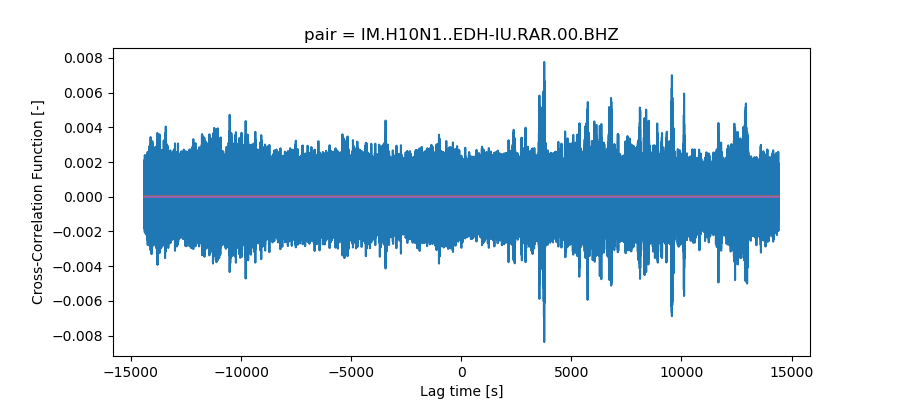

In [12]:
plt.figure(figsize=[9,4])
ds.cc.loc[{'time':ds.time[:5]}].plot.line(x='lag',add_legend=False)

### A whole period

In [ ]:
for pair in pairs:
    print('---------------------------')
    print(pair)
    print('---------------------------')
    for time in times:
        ncfile = filename(pair, time)
        if os.path.isfile(ncfile):
            ds = xr.open_dataset(ncfile)
            if np.all(ds.status.values != 0):
                ds.close()
                continue
        else:
            ds = ccf.init_dataset(
                pair=pair, 
                starttime = time, 
                endtime = time + pd.offsets.DateOffset(1), 
                preprocess = preprocess, 
                sampling_rate = sampling_rate, 
                window_length = window_length, 
                window_overlap = window_overlap, 
                clip_max_abs_lag = clip_max_abs_lag, 
                title_prefix = title_prefix
            )
        try:
            ccf.cc_dataset(ds,inventory=inv)
        except Exception as e:
            print('An error occurred. Save and continue next timestep.')
            print('Error:')
            print(e)
        ccf.write_dataset(ds,ncfile)